In [1]:
# !pip install -q -U "tensorflow-text==2.8.*"

In [2]:
# !pip install -q tf-models-official==2.7.0

In [3]:
# !pip install -q pydot

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
train_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id', usecols=['id', 'processed_description_string'])
# test_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id')
train_df = pd.read_csv('../data/processed/fewer_labels/train_7_classes.csv', index_col='id').join(train_df)
train_df = train_df[train_df['language'] == 'English'].reset_index(drop=True)
test_df = pd.read_csv('../data/processed/fewer_labels/test_7_classes.csv', index_col='id')
test_df = test_df[test_df['language'] == 'English'].reset_index(drop=True)

In [21]:
def truncate_and_split_descriptions(df, batch_size=128):
    new_df_dict = {'genre':[], 'processed_description_string': []}
    for _, row in df.iterrows():
        processed_description = row['processed_description_string'].split()
        genre = row['genre']
        n = len(processed_description)
        for i in range(0, n, batch_size):
            new_df_dict['genre'].append(genre)
            new_df_dict['processed_description_string'].append(' '.join(processed_description[i:min(n, i+batch_size)]))
    new_df = pd.DataFrame(new_df_dict)
    return new_df

In [22]:
# train_df = truncate_and_split_descriptions(train_df)

In [23]:
unique_genres = train_df['genre'].unique()
genre_encoding = dict([(unique_genres[i], i) for i in range(unique_genres.shape[0])])
train_df['genre'] = train_df['genre'].map(genre_encoding)
test_df['genre'] = test_df['genre'].map(genre_encoding)

In [24]:
train_df

,title,genre,description,year,description_stemmed,description_stemmed_string,language,processed_description_string
0,Oscar et la dame rose,0,Listening in to a conversation between his do...,2009,"['listen', 'convers', 'doctor', 'parent', '10-...",listen convers doctor parent 10-year-old oscar...,English,listen convers doctor parent 10-year-old oscar...
1,Cupid,1,A brother and sister with a past incestuous r...,1997,"['brother', 'sister', 'past', 'incestu', 'rela...",brother sister past incestu relationship curre...,English,brother sister past incestu relationship curre...
2,The Secret Sin,0,To help their unemployed father make ends mee...,1915,"['help', 'unemploy', 'father', 'make', 'end', ...",help unemploy father make end meet edith twin ...,English,help unemploy father make end meet edith twin ...
3,The Unrecovered,0,The film's title refers not only to the un-re...,2007,"['film', ""'s"", 'titl', 'refer', 'un-recov', 'b...",film 's titl refer un-recov bodi ground zero a...,English,film titl refer un-recov bodi ground zero also...
4,Quality Control,2,Quality Control consists of a series of 16mm ...,2011,"['qualiti', 'control', 'consist', 'seri', '16m...",qualiti control consist seri 16mm singl take s...,English,qualiti control consist seri 16mm singl take s...
...,...,...,...,...,...,...,...,...
39984,Kaçamak,0,A man and woman meet during the identificatio...,1988,"['man', 'woman', 'meet', 'identif', 'spous', ""...",man woman meet identif spous ' dead bodi follo...,English,man woman meet identif spous dead bodi follow ...
39985,"""Bonino""",3,This short-lived NBC live sitcom centered on ...,1953,"['short-liv', 'nbc', 'live', 'sitcom', 'center...",short-liv nbc live sitcom center bonino world-...,English,short-liv nbc live sitcom center bonino world-...
39986,Dead Girls Don't Cry,4,The NEXT Generation of EXPLOITATION. The sist...,????,"['next', 'gener', 'exploit', 'sister', 'kapa',...",next gener exploit sister kapa - bay soror hou...,English,next gener exploit sister kapa - bay soror hou...
39987,Ronald Goedemondt: Ze bestaan echt,2,"Ze bestaan echt, is a stand-up comedy about g...",2008,"['ze', 'bestaan', 'echt', 'stand-up', 'comedi'...",ze bestaan echt stand-up comedi grow face fear...,English,ze bestaan echt stand-up comedi grow face fear...


In [25]:
test_df

,title,description,year,processed_description,processed_description_string,language,genre
0,Edgar's Lunch,"L.R. Brane loves his life - his car, his apar...",1998,"['lr', 'brane', 'love', 'life', '-', 'car', 'a...",lr brane love life - car apart job especi girl...,English,1
1,La guerra de papá,"Spain, March 1964: Quico is a very naughty ch...",1977,"['spain', 'march', '1964', ':', 'quico', 'naug...",spain march 1964 : quico naughti child three b...,English,3
2,Off the Beaten Track,One year in the life of Albin and his family ...,2010,"['one', 'year', 'life', 'albin', 'famili', 'sh...",one year life albin famili shepherd north tran...,English,2
3,Meu Amigo Hindu,"His father has died, he hasn't spoken with hi...",2015,"['father', 'die', 'hasnt', 'spoken', 'brother'...",father die hasnt spoken brother 10 year seriou...,English,0
4,Er nu zhai,Before he was known internationally as a mart...,1955,"['known', 'intern', 'martial', 'art', 'superst...",known intern martial art superstar bruce lee a...,English,0
...,...,...,...,...,...,...,...
39980,Dinosaurs Decoded,National Geographic reviews Jack Horner's res...,2009,"['nation', 'geograph', 'review', 'jack', 'horn...",nation geograph review jack horner research ju...,English,2
39981,"""Tales of Light & Dark""","Covering multiple genres, Tales of Light & Da...",2013,"['cover', 'multipl', 'genr', 'tale', 'light', ...",cover multipl genr tale light dark antholog we...,English,4
39982,Der letzte Mohikaner,As Alice and Cora Munro attempt to find their...,1965,"['alic', 'cora', 'munro', 'attempt', 'find', '...",alic cora munro attempt find father british of...,English,6
39983,Slipstream,"Popular, but mysterious rock D.J Mike Mallard...",1973,"['popular', 'mysteri', 'rock', 'dj', 'mike', '...",popular mysteri rock dj mike mallard askew bro...,English,0


In [26]:
num_labels = train_df['genre'].nunique()
num_labels

7

In [27]:
x_train = train_df['processed_description_string'].values
y_train = pd.get_dummies(train_df['genre']).values

In [28]:
x_test = test_df['processed_description_string'].values
y_test = pd.get_dummies(test_df['genre']).values

In [29]:
num_examples = train_df.shape[0]

train_set_size = int(num_examples * 0.95)
val_set_size = num_examples - train_set_size

x_val = x_train[train_set_size:]
x_train = x_train[:train_set_size]

y_val = y_train[train_set_size:]
y_train = y_train[:train_set_size]

In [30]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [31]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2022-11-29 18:22:22.519617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 18:22:22.546971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 18:22:22.547121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 18:22:22.547651: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [32]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [49]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(512)(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(256)(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dense(num_labels, activation='softmax')(net)
    return tf.keras.Model(text_input, net)

In [50]:
classifier_model = build_classifier_model()

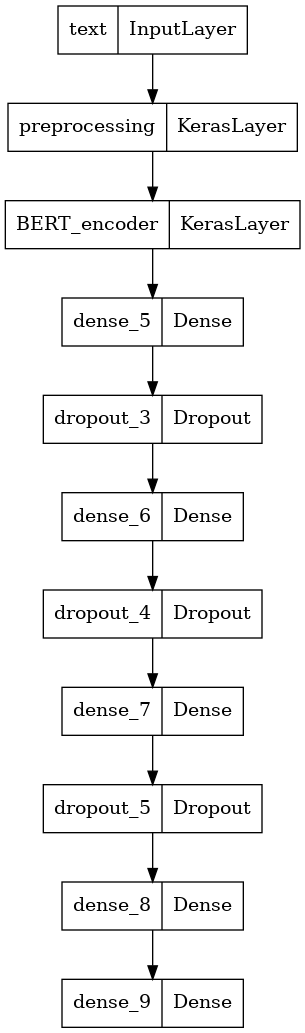

In [51]:
tf.keras.utils.plot_model(classifier_model, to_file='../models/{}.png'.format(bert_model_name))

In [52]:
epochs = 10

In [53]:
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [54]:
print(f'Training model with {tfhub_handle_encoder}')

my_callbacks  = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
history = classifier_model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=my_callbacks,
                    verbose=1
                   )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/10
1188/1188 [==============================] - 41s 33ms/step - loss: 1.0362 - accuracy: 0.6321 - val_loss: 0.8242 - val_accuracy: 0.7120
Epoch 2/10
1188/1188 [==============================] - 40s 33ms/step - loss: 0.7393 - accuracy: 0.7445 - val_loss: 0.8178 - val_accuracy: 0.7180
Epoch 3/10
1188/1188 [==============================] - 40s 33ms/step - loss: 0.5848 - accuracy: 0.8051 - val_loss: 1.0147 - val_accuracy: 0.6935


In [55]:
loss, accuracy = classifier_model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1250/1250 [==============================] - 32s 25ms/step - loss: 1.0198 - accuracy: 0.6870
Loss: 1.019843339920044
Accuracy: 0.6870326399803162


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


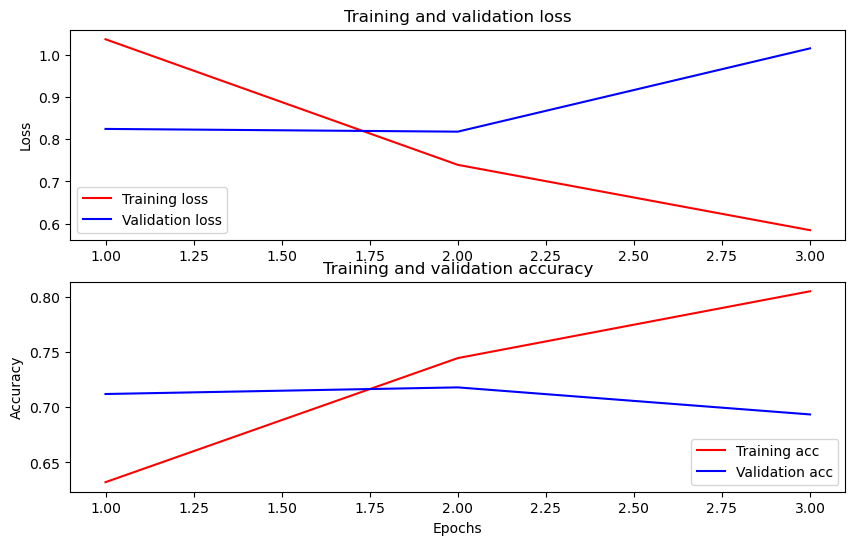

In [56]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [57]:
saved_model_path = '../models/{}'.format(bert_model_name)

classifier_model.save(saved_model_path, include_optimizer=False)

In [58]:
x_custom = np.array(['a hilarious tale'.lower()])

In [59]:
classifier_model.predict(x_custom)[0].argmax()

3

In [60]:
genre_encoding

{'drama': 0,
 'thriller': 1,
 'documentary': 2,
 'comedy': 3,
 'horror': 4,
 'action': 5,
 'western': 6}

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


def get_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(15, 15))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    plt.show()

    return None


def get_f1_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    return f1

In [62]:
y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

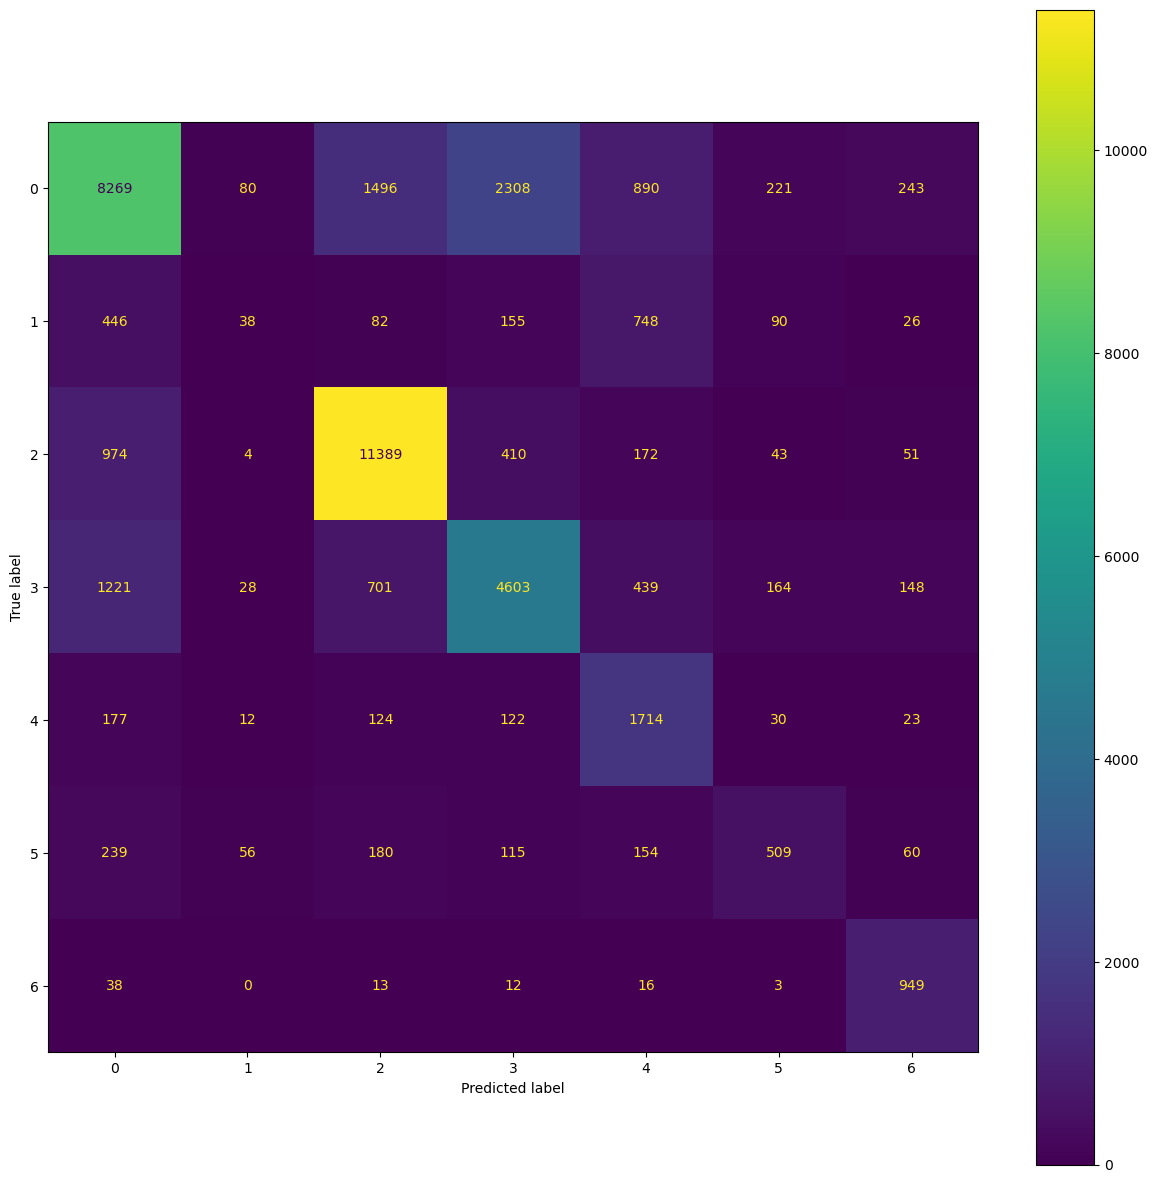

In [63]:
get_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

In [64]:
get_f1_score(np.argmax(y_test, axis=1), y_pred)

0.676313372387465